In [38]:
import time
import nrrd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import h5py

from dipy.tracking import eudx
from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel, quantize_evecs
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model, DeterministicMaximumDirectionGetter
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere
from dipy.segment.mask import median_otsu
from dipy.viz import actor, window
from dipy.io.image import save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core import gradients
from dipy.tracking.streamline import Streamlines, transform_streamlines
from dipy.tracking.utils import random_seeds_from_mask, seeds_from_mask
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table, gradient_table_from_bvals_bvecs
from dipy.reconst.dti import fractional_anisotropy
from dipy.tracking import utils

import src.dwi_tools as dwi_tools
import src.nn_helper as nn_helper

# ISMRM Processing

In [93]:
from dipy.segment.mask import median_otsu
pCaseID = 'ISMRM_2015_Tracto_challenge_data'
useDenoising = False
bvals,bvecs,gtab,dwi,aff,t1 = dwi_tools.loadISMRMData('data/%s' % (pCaseID), denoiseData = useDenoising, resliceToHCPDimensions=True)
b0_mask, binarymask = median_otsu(dwi[:,:,:,0], 2, 1)

(90, 108, 90, 33)
Reslicing to 1.25 mm^3


In [75]:
from dipy.segment.mask import median_otsu
pCaseID = 'ISMRM_2015_Tracto_challenge_data'
useDenoising = False
bvals_rs,bvecs_rs,gtab_rs,dwi_rs,aff_rs,t1_rs = dwi_tools.loadISMRMData('data/%s' % (pCaseID), denoiseData = useDenoising, resliceToHCPDimensions=True)
b0_mask, binarymask = median_otsu(dwi[:,:,:,0], 2, 1)

(90, 108, 90, 33)
Reslicing to 1.25 mm^3


In [94]:
b0 = dwi[:,:,:,0]

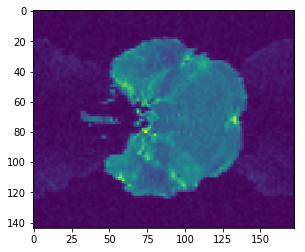

In [96]:
plt.imshow(b0[:,:,40])

In [97]:
import dipy.reconst.dti as dti
start_time = time.time()
dti_model = dti.TensorModel(gtab)
dti_fit = dti_model.fit(dwi, mask=binarymask)
dti_fit_odf = dti_fit.odf(sphere = default_sphere)
dg = DeterministicMaximumDirectionGetter
dg = dg.from_pmf(dti_fit_odf, max_angle=30., sphere=default_sphere)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

Runtime 174.40567636489868s


In [44]:
wholebrainseeds = seeds_from_mask(binarymask, affine=aff)

In [ ]:
from dipy.tracking.local import BinaryTissueClassifier
classifier = ThresholdTissueClassifier(dti_fit.fa, .15)
streamline_generator_dti = LocalTracking(dg, classifier, wholebrainseeds, aff, step_size=0.6)
streamlines_dti = list(streamline_generator_dti)
streamlines_filtered_dti = dwi_tools.filterStreamlinesByLength(streamlines_dti, 40)

In [ ]:
dwi_tools.visStreamlines(streamlines_filtered_dti)

In [ ]:
dwi_tools.saveVTKstreamlines(streamlines_filtered_dti, 'ismrm_dti_fa015.vtk')

In [45]:
response, ratio = auto_response(gtab, dwi, roi_radius=10, fa_thr=0.7)
csd_model = ConstrainedSphericalDeconvModel(gtab, response)
sphere = get_sphere('symmetric724')
start_time = time.time()
csd_peaks = peaks_from_model(model=csd_model,
                             data=dwi,
                             sphere=sphere,
                             mask=binarymask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=False)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s')
import dipy.reconst.dti as dti
start_time = time.time()
dti_model = dti.TensorModel(gtab, fit_method='LS')
dti_fit = dti_model.fit(dwi, mask=binarymask)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

/home/nico/anaconda3/lib/python3.6/site-packages/dipy/reconst/csdeconv.py:130: UserWarning: Number of parameters required for the fit are more than the actual data points
  warnings.warn(msg, UserWarning)


Runtime 749.2678763866425 s
Runtime 2.3763115406036377s


In [46]:
start_time = time.time()
classifier = ThresholdTissueClassifier(dti_fit.fa, .15)
streamlines_generator = LocalTracking(csd_peaks, classifier, wholebrainseeds, aff, step_size=0.6)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 40)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

Runtime 55.236785888671875s


In [54]:
dwi_tools.saveVTKstreamlines(streamlines_filtered, 'ismrm_csd_fa015_noreslicing.vtk')

0/67845
1000/67845
2000/67845
3000/67845
4000/67845
5000/67845
6000/67845
7000/67845
8000/67845
9000/67845
10000/67845
11000/67845
12000/67845
13000/67845
14000/67845
15000/67845
16000/67845
17000/67845
18000/67845
19000/67845
20000/67845
21000/67845
22000/67845
23000/67845
24000/67845
25000/67845
26000/67845
27000/67845
28000/67845
29000/67845
30000/67845
31000/67845
32000/67845
33000/67845
34000/67845
35000/67845
36000/67845
37000/67845
38000/67845
39000/67845
40000/67845
41000/67845
42000/67845
43000/67845
44000/67845
45000/67845
46000/67845
47000/67845
48000/67845
49000/67845
50000/67845
51000/67845
52000/67845
53000/67845
54000/67845
55000/67845
56000/67845
57000/67845
58000/67845
59000/67845
60000/67845
61000/67845
62000/67845
63000/67845
64000/67845
65000/67845
66000/67845
67000/67845
Wrote streamlines to ismrm_csd_fa015_noreslicing.vtk


In [ ]:
sl2 = dwi_tools.filterStreamlinesByCurvature(streamlines_filtered, 20)

In [98]:
b_value = 1000

In [99]:
# crop DWI data
dwi_subset, gtab_subset, bvals_subset, bvecs_subset = dwi_tools.cropDatsetToBValue(b_value, bvals, bvecs, dwi)
b0_idx = bvals < 10
b0 = dwi[..., b0_idx].mean(axis=3)
dwi_singleShell = np.concatenate((dwi_subset, dwi[..., b0_idx]), axis=3)
#    dwi_singleShell_norm = dwi_tools.normalize_dwi(dwi_singleShell, b0)
bvals_singleShell = np.concatenate((bvals_subset, bvals[..., b0_idx]), axis=0)
bvecs_singleShell = np.concatenate((bvecs_subset, bvecs[b0_idx,]), axis=0)
gtab_singleShell = gradient_table(bvals=bvals_singleShell, bvecs=bvecs_singleShell, b0_threshold = 10)

In [12]:
streamlines_filtered = dwi_tools.loadVTKstreamlines('data/ismrm_csd_fa015.vtk')

0/213617
10000/213617
20000/213617
30000/213617
40000/213617
50000/213617
60000/213617
70000/213617
80000/213617
90000/213617
100000/213617
110000/213617
120000/213617
130000/213617
140000/213617
150000/213617
160000/213617
170000/213617
180000/213617
190000/213617
200000/213617
210000/213617


In [55]:
streamlines_ismrm_curated = dwi_tools.loadVTKstreamlines('data/ismrm_csd_fa015_curated_without_fp.vtk')
sl_r = np.random.choice(streamlines_ismrm_curated,30000, replace=False)

In [103]:
trackingMethod = 'csd_ismrm_cur'

In [104]:
noX = 1
noY = 1
noZ = 1
coordinateScaling = 1
noCrossingFibres = 3
sh_order = 8
step_size = 0.6
b_value = 1000
unitTension = False

In [51]:
data_sh = dwi_tools.get_spherical_harmonics_coefficients(bvals=bvals_subset,bvecs=bvecs_subset,sh_order=sh_order, dwi=dwi_subset, b0 = b0)

Percentage erroneous voxels: 35.08


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:286: RuntimeWarning: divide by zero encountered in true_divide
  weights_normed = (weights / b0)
/home/nico/Code/deepFibreTracking/src/dwi_tools.py:286: RuntimeWarning: invalid value encountered in true_divide
  weights_normed = (weights / b0)


In [ ]:
dwi_subset_100, resamplingSphere = dwi_tools.resample_dwi(dwi_subset, b0, bvals_subset, bvecs_subset, sh_order=8, smooth=0, mean_centering=False)

Percentage erroneous voxels: 31.46


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:286: RuntimeWarning: divide by zero encountered in true_divide
  weights_normed = (weights / b0)
/home/nico/Code/deepFibreTracking/src/dwi_tools.py:286: RuntimeWarning: invalid value encountered in true_divide
  weights_normed = (weights / b0)


In [ ]:
start_time = time.time()
train_DWI,train_prevDirection, train_nextDirection,_ = dwi_tools.generateTrainingData_fstr(sl_r, dwi_subset_100, unitTension = unitTension, affine=aff, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossingFibres, step = 1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
#pTrainData = 'data/train_res100_30k_noB0InSH_step%.1f_wholeBrain_b%d_%s_%dx%dx%d_noUnitTension.h5' % (step_size,b_value,trackingMethod,noX,noY,noZ)
pTrainData = 'data/train_res100_30k_noB0InSH_step%.1f_wholeBrain_b%d_%s_%dx%dx%d_noUnitTension.h5' % (step_size,b_value,trackingMethod,noX,noY,noZ)
with h5py.File(pTrainData,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
#   f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection)

In [ ]:
start_time = time.time()
train_DWI,train_prevDirection, train_nextDirection,_ = dwi_tools.generateTrainingData_fstr(streamlines_ismrm_curated, dwi_subset_100, unitTension = unitTension, affine=aff, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossingFibres, step = 1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
#pTrainData = 'data/train_res100_30k_noB0InSH_step%.1f_wholeBrain_b%d_%s_%dx%dx%d_noUnitTension.h5' % (step_size,b_value,trackingMethod,noX,noY,noZ)
pTrainData = 'data/train_res100_all_noB0InSH_step%.1f_wholeBrain_b%d_%s_%dx%dx%d_noUnitTension.h5' % (step_size,b_value,trackingMethod,noX,noY,noZ)
with h5py.File(pTrainData,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
#   f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection)

In [16]:
tracking_data, resamplingSphere = dwi_tools.resample_dwi_forunet(dwi_subset, b0, bvals_subset, bvecs_subset, sh_order=8, smooth=0, mean_centering=False)

Percentage erroneous voxels: 35.08


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:286: RuntimeWarning: divide by zero encountered in true_divide
  weights_normed = (weights / b0)
/home/nico/Code/deepFibreTracking/src/dwi_tools.py:286: RuntimeWarning: invalid value encountered in true_divide
  weights_normed = (weights / b0)


In [ ]:
trackingMethod

In [20]:
import importlib
importlib.reload(dwi_tools)

<module 'src.dwi_tools' from '/home/nico/Code/deepFibreTracking/src/dwi_tools.py'>

In [21]:
start_time = time.time()
train_DWI_fstr,train_prevDirection_fstr, train_nextDirection_fstr, train_DWI_past_fstr = dwi_tools.generateTrainingData_fstr(sl_r, np.array(tracking_data, dtype=np.float), unitTension = unitTension, affine=aff, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossingFibres, step = 1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

Processing streamlines
0/30000
100/30000
200/30000
300/30000
400/30000
500/30000
600/30000
700/30000
800/30000
900/30000
1000/30000
1100/30000
1200/30000
1300/30000
1400/30000
1500/30000
1600/30000
1700/30000
1800/30000
1900/30000
2000/30000
2100/30000
2200/30000
2300/30000
2400/30000
2500/30000
2600/30000
2700/30000
2800/30000
2900/30000
3000/30000
3100/30000
3200/30000
3300/30000
3400/30000
3500/30000
3600/30000
3700/30000
3800/30000
3900/30000
4000/30000
4100/30000
4200/30000
4300/30000
4400/30000
4500/30000
4600/30000
4700/30000
4800/30000
4900/30000
5000/30000
5100/30000
5200/30000
5300/30000
5400/30000
5500/30000
5600/30000
5700/30000
5800/30000
5900/30000
6000/30000
6100/30000
6200/30000
6300/30000
6400/30000
6500/30000
6600/30000
6700/30000
6800/30000
6900/30000
7000/30000
7100/30000
7200/30000
7300/30000
7400/30000
7500/30000
7600/30000
7700/30000
7800/30000
7900/30000
8000/30000
8100/30000
8200/30000
8300/30000
8400/30000
8500/30000
8600/30000
8700/30000
8800/30000
8900/30000

In [36]:
pTrainData = 'data/train_res1002D_16x16_prevDWI_30k_noB0InSH_step%.1f_wholeBrain_b%d_%s_%dx%dx%d_noUnitTension.h5' % (step_size,b_value,trackingMethod,noX,noY,noZ)
with h5py.File(pTrainData,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI_fstr)
    f.create_dataset('train_DWI_prev',data=train_DWI_past_fstr)
    f.create_dataset('train_curPosition',data=train_prevDirection_fstr)   
#   f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection_fstr)

In [37]:
pTrainData

'data/train_res1002D_16x16_prevDWI_30k_noB0InSH_step0.6_wholeBrain_b1000_csd_ismrm_1x1x1_noUnitTension.h5'

In [22]:
train_DWI_past_fstr.shape

(4747501, 1, 1, 1, 256)

In [24]:
train_DWI_fstr[1000,0,0,0,10]

0.30144678866451785

In [26]:
train_DWI_past_fstr[1000+1,0,0,0,10]

0.30144678866451785

In [34]:
vv = np.stack((train_DWI_fstr, train_DWI_past_fstr))
vv = np.moveaxis(vv,0,-1)

In [35]:
vv.shape

(4747501, 1, 1, 1, 256, 2)

In [ ]:
pTrainData

In [ ]:
train_DWI_fstr.shape

In [ ]:
streamlineIndex = 0

# Preprocessing

crop multi-shell DWI to single shell data

In [ ]:
b_value = 1000
sh_order = 8
bvals,bvecs,gtab,dwi,aff,t1,binarymask = dwi_tools.loadHCPData('data/HCP/100307')
dwi_subset, gtab_subset, bvals_subset, bvecs_subset = dwi_tools.cropDatsetToBValue(b_value, bvals, bvecs, dwi)

The average b0 image is required for data normalization.

In [ ]:
b0_idx = bvals < 10
b0 = dwi[..., b0_idx].mean(axis=3)

In [ ]:
dwi_singleShell_withb0 = np.concatenate((dwi_subset, dwi[..., b0_idx]), axis=3)
bvals_singleShell_withb0 = np.concatenate((bvals_subset, bvals[..., b0_idx]), axis=0)
bvecs_singleShell_withb0 = np.concatenate((bvecs_subset, bvecs[b0_idx,]), axis=0)
gtab_singleShell_withb0 = gradient_table(bvals=bvals_singleShell_withb0, bvecs=bvecs_singleShell_withb0, b0_threshold = 10)

In [ ]:
dwi_subset_ressampled, resamplingSphere = dwi_tools.resample_dwi(dwi_subset, b0, bvals_subset, bvecs_subset, sh_order=8, smooth=0, mean_centering=False)

# Tractography

In this section we'll generate streamlines using different approaches. This is gonna be the foundation for the evaluation of our method. We'll also employ simulated as well as curated data for our analysis.

In [ ]:
step_size = 0.6 # mm

In [ ]:
# roi_idx = (slice(20, 50), slice(55, 85), slice(38, 39)) #  splenium of the corpus callosum
ccmask, options = nrrd.read('data/HCP/100307/100307-ccSegmentation.nrrd')
ccseeds = seeds_from_mask(ccmask, affine=aff)
wholebrainseeds = seeds_from_mask(binarymask, affine=aff)
validationSeeds = ccseeds[45:48]
rndseeds = random_seeds_from_mask(binarymask, seeds_count=4000, seed_count_per_voxel=False, affine=aff)

## Single Tensor Model

In [ ]:
import dipy.reconst.dti as dti
start_time = time.time()
dti_model = dti.TensorModel(gtab_subset)
dti_fit = dti_model.fit(dwi_subset, mask=binarymask)
dti_fit_odf = dti_fit.odf(sphere = default_sphere)
dg = DeterministicMaximumDirectionGetter
dg = dg.from_pmf(dti_fit_odf, max_angle=30., sphere=default_sphere)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

---
STM using spherical harmonics

In [ ]:
from dipy.data import default_sphere
from dipy.direction import DeterministicMaximumDirectionGetter

start_time = time.time()

csd_model = ConstrainedSphericalDeconvModel(gtab_singleShell, None, sh_order=sh_order)
csd_fit = csd_model.fit(dwi_singleShell_norm, mask=binarymask)


dg = DeterministicMaximumDirectionGetter.from_shcoeff(csd_fit.shm_coeff,
                                                             max_angle=30.,
                                                             sphere=default_sphere)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

---
track streamlines

In [ ]:
from dipy.tracking.local import BinaryTissueClassifier
classifier = ThresholdTissueClassifier(dti_fit.fa, .15)
streamline_generator_dti = LocalTracking(dg, classifier, wholebrainseeds, aff, step_size=step_size)
streamlines_dti = list(streamline_generator_dti)
streamlines_filtered_dti = dwi_tools.filterStreamlinesByLength(streamlines_dti, 40)

In [ ]:
dwi_tools.visStreamlines(streamlines_filtered_dti)

In [ ]:
import importlib
importlib.reload(dwi_tools)
import src.dwi_tools as dwi_tools
from dipy.tracking.streamline import transform_streamlines
streamlines_imageCS = transform_streamlines(sl_r,np.linalg.inv(aff)) # project streamlines from RAS into image (voxel) coordinate system

---
---
## Q-ball Reconstruction
---
---

In [ ]:
csamodel = CsaOdfModel(gtab, 4)
sphere = get_sphere('symmetric724')
start_time = time.time()
csapeaks = peaks_from_model(model=csamodel,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False)

GFA = csapeaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

tracking

In [ ]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(csapeaks, classifier, seeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

---
---
## Constrained Spherical Deconvolution
---
---

Use in case of b = 2,500 – 3,000 s/mm² data

In [ ]:
response, ratio = auto_response(gtab_singleShell_withb0, dwi_singleShell_withb0, roi_radius=10, fa_thr=0.7)
csd_model = ConstrainedSphericalDeconvModel(gtab_singleShell_withb0, response)
sphere = get_sphere('symmetric724')

In [ ]:
start_time = time.time()
csd_peaks = peaks_from_model(model=csd_model,
                             data=dwi_singleShell_withb0,
                             sphere=sphere,
                             mask=binarymask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=False)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s')

In [ ]:
import dipy.reconst.dti as dti
start_time = time.time()
dti_model = dti.TensorModel(gtab_singleShell_withb0, fit_method='LS')
dti_fit = dti_model.fit(dwi_singleShell_withb0, mask=binarymask)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

In [ ]:
start_time = time.time()
classifier = ThresholdTissueClassifier(dti_fit.fa, .2)
streamlines_generator = LocalTracking(csd_peaks, classifier, wholebrainseeds, aff, step_size=step_size)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

In [ ]:
step_size

In [ ]:
dwi_tools.visStreamlines(streamlines_filtered)

In [ ]:
pBaselineStreamlines = 'data/train_step%.1f_wholeBrain_b%d_2_csd_peaks.vtk' % (step_size,b_value)
dwi_tools.saveVTKstreamlines(streamlines_filtered,pBaselineStreamlines)

In [ ]:
start_time = time.time()
csd_fit = csd_model.fit(dwi_singleShell_withb0, mask=binarymask)
dg = DeterministicMaximumDirectionGetter.from_shcoeff(csd_fit.shm_coeff,
                                                      max_angle=30.,
                                                      sphere=sphere)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

In [ ]:
start_time = time.time()
classifier = ThresholdTissueClassifier(dti_fit.fa, .2)
streamlines_generator = LocalTracking(dg, classifier, wholebrainseeds, aff, step_size=step_size)
streamlines_dg = Streamlines(streamlines_generator)
streamlines_filtered_dg = dwi_tools.filterStreamlinesByLength(streamlines_dg, 50)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

In [ ]:
pBaselineStreamlines = 'data/train_step%.1f_wholeBrain_b%d_csd_deterministic.vtk' % (step_size,b_value)
dwi_tools.saveVTKstreamlines(streamlines_filtered_dg,pBaselineStreamlines)

# Generate Training data

In [ ]:
sl_r = np.random.choice(streamlines_filtered,30000, replace=False)

### old fashioned

In [ ]:
trackingMethod = 'csd_ismrm'
#sl_r = streamlines_ukf_curated
#trackingMethod = 'ukf_curated'
#sl_r = streamlines_csd_peaks_curated
#trackingMethod = 'csd_curated'

In [ ]:
data_sh = dwi_tools.get_spherical_harmonics_coefficients(bvals=bvals,bvecs=bvecs,sh_order=sh_order, dwi=dwi, b0 = b0)

In [ ]:
noX = 1
noY = 1
noZ = 1
coordinateScaling = 1
noCrossingFibres = 3
sh_order = 8

In [ ]:
importlib.reload(dwi_tools)
data_sh = dwi_tools.get_spherical_harmonics_coefficients(bvals=bvals_subset,bvecs=bvecs_subset,sh_order=sh_order, dwi=dwi_subset, b0 = b0)

In [ ]:
import importlib
importlib.reload(dwi_tools) 
import src.dwi_tools as dwi_tools

#rawData = dwi_singleShell_norm
#rawData = dtiPeakDirs
#rawData = dti_fit.quadratic_form.reshape([145,174,145,9])
#rawData = dti_fit_odf
#rawData = csd_fit.shm_coeff # spherical harmonics
#rawData = dwi_tools.get_spherical_harmonics_coefficients(bvals=bvals_singleShell,bvecs=bvecs_singleShell,sh_order=sh_order, dwi=dwi_singleShell_norm, b0 = 0)
#rawData = dwi_subset_ressampled
rawData = data_sh

start_time = time.time()
train_DWI,train_prevDirection, train_nextDirection = dwi_tools.generateTrainingData(sl_r, rawData, unitTension = True, affine=aff, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossingFibres, step = 1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
pTrainData = 'data/train_sh%d_noB0InSH_step%.1f_wholeBrain_b%d_2_%s_%dx%dx%d.h5' % (sh_order,step_size,b_value,trackingMethod,noX,noY,noZ)
with h5py.File(pTrainData,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
#   f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection)

In [ ]:
pTrainData

In [ ]:
dwi_tools.saveVTKstreamlines(sl_r,pBaselineStreamlines)

### 2D projection of DWI coefficients

In [ ]:
importlib.reload(dwi_tools)
dwi_subset_ressampled, resamplingSphere = dwi_tools.resample_dwi_forunet(dwi_subset, b0, bvals_subset, bvecs_subset, sh_order=8, smooth=0, mean_centering=False)
raw_data = dwi_subset_ressampled

start_time = time.time()
train_DWI,train_prevDirection, train_nextDirection = dwi_tools.generate2DUnrolledTrainingData(sl_r, raw_data, resamplingSphere = resamplingSphere, affine=aff, coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossingFibres, step = 1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
pTrainData = 'data/train_resampled_10x10_noB0InSH_step%.1f_wholeBrain_b%d_2_%s.h5' % (step_size,b_value,trackingMethod)
pTrainData

In [ ]:
with h5py.File(pTrainData,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
#   f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection)   

# Generate data from UKF streamlines

In [ ]:
streamlines = dwi_tools.loadVTKstreamlines('data/HCP/ukf_103818_b1000.vtk')

In [ ]:
streamlines_imageCS = transform_streamlines(sl_r,np.linalg.inv(aff)) # project streamlines from RAS into image (voxel) coordinate system
dwi_tools.visStreamlines(streamlines_imageCS, dwi_subset[:,:,:,0])

In [ ]:
sl_r = np.random.choice(streamlines,30000, replace=False)

In [ ]:
b_value = 1000
sh_order = 8
bvals,bvecs,gtab,dwi,aff,t1,binarymask = dwi_tools.loadHCPData('data/HCP/100307')
dwi_subset, gtab_subset, bvals_subset, bvecs_subset = dwi_tools.cropDatsetToBValue(b_value, bvals, bvecs, dwi)

# crop DWI data
b0_idx = bvals < 10
b0 = dwi[..., b0_idx].mean(axis=3)

dwi_singleShell_withb0 = np.concatenate((dwi_subset, dwi[..., b0_idx]), axis=3)
bvals_singleShell_withb0 = np.concatenate((bvals_subset, bvals[..., b0_idx]), axis=0)
bvecs_singleShell_withb0 = np.concatenate((bvecs_subset, bvecs[b0_idx,]), axis=0)
gtab_singleShell_withb0 = gradient_table(bvals=bvals_singleShell_withb0, bvecs=bvecs_singleShell_withb0, b0_threshold = 10)

In [ ]:
wholebrainseeds = seeds_from_mask(binarymask, affine=aff)

In [ ]:
data_sh = dwi_tools.get_spherical_harmonics_coefficients(bvals=bvals_subset,bvecs=bvecs_subset,sh_order=sh_order, dwi=dwi_subset, b0 = b0)

In [ ]:
import importlib
importlib.reload(dwi_tools) 
import src.dwi_tools as dwi_tools

rawData = data_sh

start_time = time.time()
train_DWI,train_prevDirection, train_nextDirection = dwi_tools.generateTrainingData(sl_r, rawData, unitTension = True, affine=aff, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossingFibres, step = 1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
trackingMethod = 'ukf_b1000real'

In [ ]:
pTrainData = 'data/train_sh%d_noB0InSH_step%.1f_wholeBrain_b%d_2_%s_%dx%dx%d.h5' % (sh_order,step_size,b_value,trackingMethod,noX,noY,noZ)
with h5py.File(pTrainData,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
#   f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection)

# Create curated dataset

In [65]:
import os
import src.wma_interactor as wma

In [ ]:
wmaPath = '/home/nico/Code/wma'

In [ ]:
print('cd ' + wmaPath)

In [ ]:
print('./bin/python ./bin/wm_cluster_from_atlas.py ~/Code/deepFibreTracking/' + pBaselineStreamlines + ' ORG-800FC-100HCP-minimal-atlas/ atlas_output/')

In [ ]:
print('./bin/python ./bin/wm_cluster_remove_outliers.py atlas_output/' + os.path.split(pBaselineStreamlines)[-1] + ' ORG-800FC-100HCP-minimal-atlas/ atlas_output_cleaned/')

In [ ]:
streamlines_csd_peaks_curated = wma.loadAllMRMLStreamlinesFromDirectory('/home/nico/Code/wma/atlas_output_cleaned/train_step0.6_wholeBrain_b1000_2_csd_peaks_outlier_removed/')

In [ ]:
streamlines_ukf_curated = wma.loadAllMRMLStreamlinesFromDirectory('/home/nico/Code/wma/atlas_output_cleaned/ukf_tractography_b3000_outlier_removed')

In [ ]:
dwi_tools.visTwoSetsOfStreamlines(streamlines_csd_peaks_curated,streamlines_ukf_curated,t1)

In [ ]:
dwi_tools.visStreamlines(streamlines_ukf_curated)

In [ ]:
dwi_tools.saveVTKstreamlines(streamlines=streamlines_ukf_curated, pStreamlines='data/ukf_curated.vtk')

In [ ]:
len(streamlines_filtered)

In [66]:
streamlines_curated = wma.loadAllMRMLStreamlinesFromDirectory('/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed/')

/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed/T_AF.mrml
/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed/T_CB.mrml
/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed/T_CC1.mrml
/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed/T_CC2.mrml
/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed/T_CC3.mrml
/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed/T_CC4.mrml
/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed/T_CC5.mrml
/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed/T_CC6.mrml
/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed/T_CC7.mrml
/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed/T_CPC.mrml
/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed/T_CR-F.mrml
/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed/T_CR-P.mrml
/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_remov

In [78]:
aff = np.array([[1,0,0,-87], [0,1,0,-89], [0,0,1,74], [0,0,0,1]])

In [82]:
np.linalg.inv(aff)

array([[  1.,   0.,   0.,  87.],
       [  0.,   1.,   0.,  89.],
       [  0.,   0.,   1., -74.],
       [  0.,   0.,   0.,   1.]])

In [72]:
dwi_tools.saveVTKstreamlines(streamlines=streamlines_curated, pStreamlines='/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed_all_without_fp.vtk')

0/108262
1000/108262
2000/108262
3000/108262
4000/108262
5000/108262
6000/108262
7000/108262
8000/108262
9000/108262
10000/108262
11000/108262
12000/108262
13000/108262
14000/108262
15000/108262
16000/108262
17000/108262
18000/108262
19000/108262
20000/108262
21000/108262
22000/108262
23000/108262
24000/108262
25000/108262
26000/108262
27000/108262
28000/108262
29000/108262
30000/108262
31000/108262
32000/108262
33000/108262
34000/108262
35000/108262
36000/108262
37000/108262
38000/108262
39000/108262
40000/108262
41000/108262
42000/108262
43000/108262
44000/108262
45000/108262
46000/108262
47000/108262
48000/108262
49000/108262
50000/108262
51000/108262
52000/108262
53000/108262
54000/108262
55000/108262
56000/108262
57000/108262
58000/108262
59000/108262
60000/108262
61000/108262
62000/108262
63000/108262
64000/108262
65000/108262
66000/108262
67000/108262
68000/108262
69000/108262
70000/108262
71000/108262
72000/108262
73000/108262
74000/108262
75000/108262
76000/108262
77000/108262

In [68]:
sl2 = dwi_tools.loadVTKstreamlines('/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed_all.vtk')

0/168577
10000/168577
20000/168577
30000/168577
40000/168577
50000/168577
60000/168577
70000/168577
80000/168577
90000/168577
100000/168577
110000/168577
120000/168577
130000/168577
140000/168577
150000/168577
160000/168577


In [86]:
sl4 = dwi_tools.loadVTKstreamlines('data/ISMRM_CSD_Atlas_Registered/ismrm_csd_fa015.vtk')

0/213617
10000/213617
20000/213617
30000/213617
40000/213617
50000/213617
60000/213617
70000/213617
80000/213617
90000/213617
100000/213617
110000/213617
120000/213617
130000/213617
140000/213617
150000/213617
160000/213617
170000/213617
180000/213617
190000/213617
200000/213617
210000/213617


In [88]:
sl4_ijk = transform_streamlines(sl4, np.linalg.inv(aff_rs))

In [91]:
dwi_tools.visStreamlines(sl3_ijk, dwi_rs[:,:,:,0])

Lsl:108262


/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/home/nico/anaconda3/lib/pyt

In [73]:
sl3 = dwi_tools.loadVTKstreamlines('data/ismrm_csd_fa015_curated_without_fp.vtk')

0/108262
10000/108262
20000/108262
30000/108262
40000/108262
50000/108262
60000/108262
70000/108262
80000/108262
90000/108262
100000/108262


In [90]:
sl3_ijk = transform_streamlines(sl3, np.linalg.inv(aff_rs))